# Extract colorectal polyps and non-polyps images

** Warning: this project will contain explicit anatomicaly images from a colonoscopy! **

The main project is about creating a tool for polyps detection in colonoscopy videos using Deep Learning. The video could be replaced with webcam inputs with small modifications. The tool will be creating as a Web application that will run in the client device by using Tensorflow.js. The main steps of the project are:
1. Create a dataset for a deep learning classifier (polyps vs non-polyps images)
2. Find the best classifier using CNN and transfer learning
3. Integrate the best classifier into a simple polyps detection script.

The advantages of using Tensorflow.js are:
* Privacy 100%: The entire prediction will not leave the user device (no data will be send to a server).
* Mobility: The file can run in any device and it will use if possible the user GPU.

Sources:
* http://site.uit.no/deephealthresearch/2017/07/19/polyp-detection-using-deep-learning/
* https://www.dropbox.com/s/p5qe9eotetjnbmq/CVC-ClinicDB.rar?dl=0

In the first step, to create a polyps / non-polyps images dataset, we shall use the downloaded dataset and we shall extract only the polyps and non-polyps images from all original images. This step is using original images including colorectal polyps and the ground truth images.

You should download the images and the result will be two subfolders in the `downloaded` folder:
* `Original`: images with colorectal polyps from where we will extract polyps and non-polyps images
* `Ground Truth`: black and white images with the polyp localization corresponding with the original images

With both images you should localize the polyps in the original image. The new images will be saved into `cropped` folder. You should have 2 subfolders: `polyps` and `non_polyps` (or modify the code with other paths).

Let's load the main packages for this image processing:

In [1]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
import matplotlib.pyplot as plt
import skimage.io
import numpy as np
import os

# plots in jupyter notebooks
%matplotlib inline

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········


In order to understand what images we will procces, let's visualize the Original and Ground Truth images for one case. We will use `Skimage` package for Original images and `Keras` package for the Ground Truth images. At the end of the file you can find some errors and strange results when we used other packages.

Show an Original image:

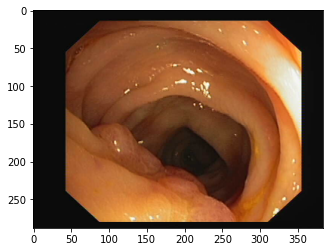

In [0]:
# Load an original image
original = skimage.io.imread('/content/drive/My Drive/Colab Notebooks/dataset/Original/3.tif', plugin='tifffile')
plt.imshow(original) # plot image

Show the correspondent Ground Thruth image (localization of the polyp in the Original image):

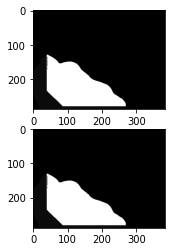

In [0]:
# Load the ground truth image
thruth = load_img('/content/drive/My Drive/Colab Notebooks/dataset/GroundTruth/3.tif')
thruth_array = img_to_array(thruth)  # this is a Numpy array
thruth_array = thruth_array * 1./255 # image normalization for keras
plt.subplot(2, 1, 1)
plt.imshow(thruth)
plt.subplot(2, 1, 2)
plt.imshow(thruth_array)
# plot image

### How to extract polyp images

For each image in `Original` will shall:
1. Eliminate black margine: First, we observe a black margin in the `Original` images and, therefore, we shall remove it. 
2. Extract polyps as images: We need to extract the correspondent section image from Original images that is white in the Ground Truth image. 
3. Extract non-polyp images from the original ones.

Let's declare the folders and the minimum box to crop from images for the non-poly images. Let's say we want `150x150` pixels for the non-polyp images. For the polyp images, we shall crop the polyp from `Original` using the white section from the `Ground Truth` image. The generated images will have the same name as the Original ones.

In [0]:
# Define the image folders for the downloaded images = to be processed
OriginalFolder    = '/content/drive/My Drive/Colab Notebooks/dataset/Original'
GroundTruthFolder = '/content/drive/My Drive/Colab Notebooks/dataset/GroundTruth'

# Define the image folders for the cropped images = resulted from this script
PolypsFolder      = '/content/drive/My Drive/Colab Notebooks/dataset/cropped/polyps'
nonPolypsFolder   = '/content/drive/My Drive/Colab Notebooks/dataset/cropped/non_polyps'

# Minimum box to crop for non-polyp images
min_box = 150 # get box of 150 x 150 pixels

Get the list of files to process and print the file counting for checkings:

In [0]:
orFiles = os.listdir(OriginalFolder)
gtFiles = os.listdir(GroundTruthFolder)
print('Original files:', OriginalFolder, len(orFiles), '\nGround Truth files:', GroundTruthFolder, len(gtFiles))

Original files: /content/drive/My Drive/Colab Notebooks/dataset/Original 612 
Ground Truth files: /content/drive/My Drive/Colab Notebooks/dataset/GroundTruth 612


In [0]:
# Crop polys as new images
print('--> Cropping polyps as images ...')
# For each image in Original folder
for iFile in orFiles:
    # Get full path for original / source image = folder + filename
    sourceFile = os.path.join(OriginalFolder,iFile)
    # Get full path for polyp location image = folder + filename
    locationFile = os.path.join(GroundTruthFolder,iFile)
    # Get full path for polyp cropped image = folder + filename
    polypFile = os.path.join(PolypsFolder,iFile)
    # Get full path for non-polyp cropped image = folder + filename
    nonpolypFile = os.path.join(nonPolypsFolder,iFile)
    
    # Read the original image
    img_o_array = skimage.io.imread(sourceFile, plugin='tifffile') # array with pixel data
    # Remove black margins using manual values from trials
    img_o_array = img_o_array[30:280,90:220+90,:]
    
    # Read ground truth image
    img_gt = load_img(locationFile)
    img_gt_array = img_to_array(img_gt)  # this is a Numpy array
    img_gt_array = img_gt_array * 1./255 # image normalization for keras
    # Remove the black margins
    img_gt_array = img_gt_array[30:280,90:220+90,:]
    
    # Apply mask for ground truth image: find non-black pixels!
    mask = img_gt_array > [0,0,0] # using 3 channels
    # Get coordinates of non-black pixels using only one channel data!
    coords = np.argwhere(mask[:,:,0])
    # Set bounding box of non-black pixels (used to define the polyp cropping area)
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1   # slices are exclusive at the top
    
    # Get the cropped image with a polyp from the original image
    cropped = img_o_array[x0:x1, y0:y1,:]
    
    # SAVE the croped image as a polyp image in 'cropped/1-Polyps' (jpg format)
    plt.imsave(polypFile[:-4]+'.jpg', cropped)

print('Done!')

--> Cropping polyps as images ...
Done!


#### Checking a polyp cropped image

Please remember that the polyp images will have different dimensions depending of the white area from the `Ground Truth` images.

/content/drive/My Drive/Colab Notebooks/dataset/cropped/polyps/309.jpg


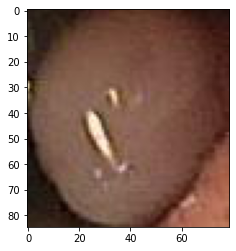

In [0]:
one_polyp = skimage.io.imread(polypFile[:-4]+'.jpg')
print(polypFile[:-4]+'.jpg')
plt.imshow(one_polyp) # plot image

### How to extract non-polyp images

In the second step, after extracting the polyps, we are going to generate non-polyp images: we shall use the same original image and we shall get non-polyp sections arround the polyps. The script will generate only one non_polyp image. Thus, the generated files will be 1:1 (polyp:non-polyp).

In [0]:
# Crop non-polys as new images (one image for each polyp)
print('--> Cropping non-polyps as images ...')
# For each image in Original folder
for iFile in orFiles:
    # Get full path for original / source image = folder + filename
    sourceFile = os.path.join(OriginalFolder,iFile)
    # Get full path for polyp location image = folder + filename
    locationFile = os.path.join(GroundTruthFolder,iFile)
    # Get full path for polyp cropped image = folder + filename
    polypFile = os.path.join(PolypsFolder,iFile)
    # Get full path for non-polyp cropped image = folder + filename
    nonpolypFile = os.path.join(nonPolypsFolder,iFile)
    
    # Read the original image
    img_o_array = skimage.io.imread(sourceFile, plugin='tifffile') # array with pixel data
    # Remove black margins using manual values from trials
    img_o_array = img_o_array[30:280,90:220+90,:]
    
    # Read ground truth image
    img_gt = load_img(locationFile)
    img_gt_array = img_to_array(img_gt)  # this is a Numpy array
    img_gt_array = img_gt_array * 1./255 # image normalization for keras
    # Remove the black margins
    img_gt_array = img_gt_array[30:280,90:220+90,:]
    
    # Apply mask for ground truth image: find non-black pixels!
    mask = img_gt_array > [0,0,0] # using 3 channels
    # Get coordinates of non-black pixels using only one channel data!
    coords = np.argwhere(mask[:,:,0])
    # Set bounding box of non-black pixels (used to define the polyp cropping area)
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1   # slices are exclusive at the top
    
    # Get one of the 4 images from left, right, up and bottom to the polyp
    # Get original image x, y (image dimension)
    x, y, ch = img_o_array.shape
    
    
    # Get one section fron up or down (relative to the polyp)
    if (x - x1) > x0:
        x_i = x1
        x_f = x
        y_i = 0
        y_f = y
    else:
        x_i = 0
        x_f = x0
        y_i = 0
        y_f = y
    up_down = img_o_array[x_i:x_f,y_i:y_f,:]
    
    # Get one section fron left or rigth (relative to the polyp)
    if (y - y1) > y0:
        y_i = y1
        y_f = y
        x_i = 0
        x_f = x
    else:
        y_i = 0
        y_f = y0
        x_i = 0
        x_f = x
        
    left_right = img_o_array[x_i:x_f,y_i:y_f,:]
    
    # If area of up_down image is greater than left_right, save as non_polyp the up_down image; else save left-right
    surface_up_down    = up_down.shape[0] * up_down.shape[1]
    surface_left_right = left_right.shape[0] * left_right.shape[1]
    if surface_up_down > surface_left_right:
        non_polyp = up_down
    else:
        non_polyp = left_right
    # If surface of the result is different of zero, save it!
    surface_non_polyp = non_polyp.shape[0] * non_polyp.shape[1]
    if surface_non_polyp!=0:
        plt.imsave(nonpolypFile[:-4]+'.jpg', non_polyp)
    else:
        # If non-polyp area is zero print an error message
        print('Without non-polys:', nonpolypFile)

print("Done!")

--> Cropping non-polyps as images ...
Without non-polys: /content/drive/My Drive/Colab Notebooks/dataset/cropped/non_polyps/478.tif
Without non-polys: /content/drive/My Drive/Colab Notebooks/dataset/cropped/non_polyps/490.tif
Without non-polys: /content/drive/My Drive/Colab Notebooks/dataset/cropped/non_polyps/22.tif
Done!


Due to these errors of cropping we have only 609 non-polyp files (compared with 612 original files). Thus, the cropped dataset has 612 polyps and 609 non-polyps. After manual inspection of the files, we decide to remove couple of images:
* from polyps: 55, 67, 178, 329, 559, 82;
* from non-polyps: 25, 476, 477.
Thus, the final dataset has **1212** examples, **606** for polyps and **606** for non-polyps.

In [0]:
# Remove a specific list of files from cropped polyps
for iFileToRemove in [55, 67, 178, 329, 559, 82]:
    # Get full path for polyp cropped image = folder + filename
    polypFile = os.path.join(PolypsFolder,str(iFileToRemove)+'.jpg')
    try:
        print("--> Removing file:", polypFile)
        os.remove(polypFile)
    except:
        print("----> Error:", polypFile, "do not exists!")

--> Removing file: /content/drive/My Drive/Colab Notebooks/dataset/cropped/polyps/55.jpg
--> Removing file: /content/drive/My Drive/Colab Notebooks/dataset/cropped/polyps/67.jpg
--> Removing file: /content/drive/My Drive/Colab Notebooks/dataset/cropped/polyps/178.jpg
--> Removing file: /content/drive/My Drive/Colab Notebooks/dataset/cropped/polyps/329.jpg
--> Removing file: /content/drive/My Drive/Colab Notebooks/dataset/cropped/polyps/559.jpg
--> Removing file: /content/drive/My Drive/Colab Notebooks/dataset/cropped/polyps/82.jpg


In [0]:
# Remove a specific list of files from cropped non-polyps
for iFileToRemove in [25, 476, 477]:
    # Get full path for polyp cropped image = folder + filename
    nonpolypFile = os.path.join(nonPolypsFolder,str(iFileToRemove)+'.jpg')
    try:
        print("--> Removing file:", nonpolypFile)
        os.remove(nonpolypFile)
    except:
        print("----> Error:", nonpolypFile, "do not exists!")

--> Removing file: /content/drive/My Drive/Colab Notebooks/dataset/cropped/non_polyps/25.jpg
--> Removing file: /content/drive/My Drive/Colab Notebooks/dataset/cropped/non_polyps/476.jpg
--> Removing file: /content/drive/My Drive/Colab Notebooks/dataset/cropped/non_polyps/477.jpg


Let's check the final dataset number of files. It should be 606 cropped polyps vs 606 npn-polyps:

In [0]:
print('Cropped polyps:', len(os.listdir(PolypsFolder)), '\nCropped non-polyps:', len(os.listdir(nonPolypsFolder)))

Cropped polyps: 606 
Cropped non-polyps: 606


In the next scripts, we need to split these files into `train` and `validation` subsets for each class (see [2-Spit_Dataset.ipynb](./2-Spit_Dataset.ipynb)). Before to go for the next script, we check the results and show some errors we found.